In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
tensor_transform = transforms.Compose([
    transforms.CenterCrop((128,128)),
    #transforms.Resize((224, 224)),
    transforms.ToTensor()
])
#dataset = datasets.MNIST(root="./data", train=True, download=True, transform=tensor_transform)
dirs = {}
dirs['source_images'] = '/home/alex/Data/Work/Sources/galaxy-zoo-the-galaxy-challenge/galzoo'
train_data = datasets.ImageFolder(root=dirs['source_images'],transform=tensor_transform,)
loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=4, shuffle=False)

In [3]:
class TinyAE(nn.Module):
    def __init__(self):
        super(TinyAE, self).__init__()

        # Encoder
        self.enc1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)     # [32, 64, 64]
        self.enc2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)    # [64, 32, 32]
        self.enc3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)   # [128, 16, 16]

        # Decoder
        self.dec1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)   # [64, 32, 32]
        self.dec2 = nn.ConvTranspose2d(128, 32, 3, stride=2, padding=1, output_padding=1)   # [32, 64, 64]
        self.dec3 = nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1)     # [3, 128, 128]

        self.relu = nn.ReLU()

    def forward(self, x):
        e1 = self.relu(self.enc1(x))     # [32, 64, 64]
        e2 = self.relu(self.enc2(e1))    # [64, 32, 32]
        e3 = self.relu(self.enc3(e2))    # [128, 16, 16]

        d1 = self.relu(self.dec1(e3))    # [64, 32, 32]
        d2 = self.relu(self.dec2(torch.cat([d1, e2], dim=1)))  # [32, 64, 64]
        d3 = torch.tanh(self.dec3(torch.cat([d2, e1], dim=1))) # [3, 128, 128]

        return d3

    def encode(self, x):
        with torch.no_grad():
            x = self.relu(self.enc1(x))
            x = self.relu(self.enc2(x))
            x = self.relu(self.enc3(x))
        return x  # [128, 16, 16]

In [3]:
class PureBottleneckAE(nn.Module):
    def __init__(self, latent_dim=16):
        super(PureBottleneckAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),  # [32, 64, 64]
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # [64, 32, 32]
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # [128, 16, 16]
            nn.ReLU(),
        )

        # Bottleneck
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 16 * 16, latent_dim)  # compress
        self.fc2 = nn.Linear(latent_dim, 128 * 16 * 16)  # decompress

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # [64, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),   # [32, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),    # [3, 128, 128]
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        flat = self.flatten(encoded)
        bottleneck = self.fc1(flat)
        unflat = self.fc2(bottleneck).view(-1, 128, 16, 16)
        decoded = self.decoder(unflat)
        return decoded

    def encode(self, x):
        with torch.no_grad():
            x = self.encoder(x)
            x = self.flatten(x)
            z = self.fc1(x)
        return z  # [batch_size, latent_dim]

In [4]:
model = PureBottleneckAE(64)
loss_function = nn.MSELoss()
#loss_function = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

Epoch 1/20, Loss: 0.001701
Epoch 2/20, Loss: 0.001295
Epoch 3/20, Loss: 0.001018
Epoch 4/20, Loss: 0.000939
Epoch 5/20, Loss: 0.000908
Epoch 6/20, Loss: 0.000866
Epoch 7/20, Loss: 0.000863
Epoch 8/20, Loss: 0.000833
Epoch 9/20, Loss: 0.000793
Epoch 10/20, Loss: 0.000881
Epoch 11/20, Loss: 0.000827
Epoch 12/20, Loss: 0.000748
Epoch 13/20, Loss: 0.000760
Epoch 14/20, Loss: 0.000701
Epoch 15/20, Loss: 0.000777
Epoch 16/20, Loss: 0.000746
Epoch 17/20, Loss: 0.000685
Epoch 18/20, Loss: 0.000685
Epoch 19/20, Loss: 0.000703
Epoch 20/20, Loss: 0.000722


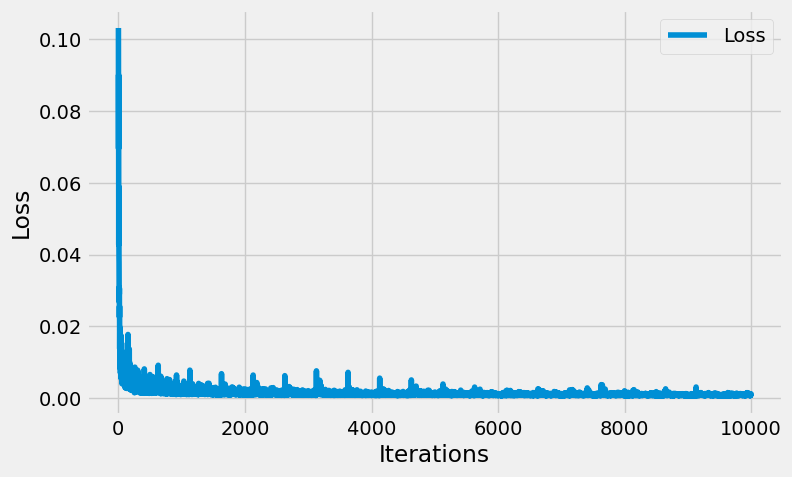

In [5]:
epochs = 20
outputs = []
losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    for images, _ in loader:
        images = images.view(-1, 3, 128, 128).to(device)
        #images = images.view(-1, 3, 256, 256).to(device)
        
        reconstructed = model(images)
        loss = loss_function(reconstructed, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    outputs.append((epoch, images, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
loader2 = torch.utils.data.DataLoader(dataset=train_data, batch_size=5, shuffle=False)
model.eval()
dataiter = iter(loader2)

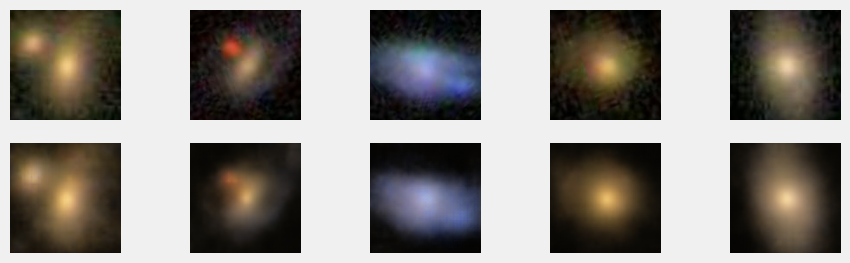

In [9]:
images, _ = next(dataiter)

images = images.view(-1, 3, 128, 128).to(device)
reconstructed = model(images)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 3))
for i in range(5):
    axes[0, i].imshow(Image.fromarray((images[i].cpu().detach().numpy()*255).astype(np.uint8).T))
    axes[0, i].axis('off')
    axes[1, i].imshow(Image.fromarray((reconstructed[i].cpu().detach().numpy()*255).astype(np.uint8).T))
    axes[1, i].axis('off')
plt.show()

In [10]:
loader2 = torch.utils.data.DataLoader(dataset=train_data, batch_size=50, shuffle=False)
features = []
for images, _ in loader2:
    f = model.encode(images.view(-1, 3, 128, 128).to(device))
    #pooled_features = torch.mean(f, dim=(2, 3))
    features.append(f.cpu().detach().numpy())

In [11]:
features = np.concatenate(features)

In [12]:
output_file = 'features/autoencoderMSE_features_galaxyzoo.npy'
np.save(output_file,features)

In [13]:
torch.save(model, 'models/ae_bottleneck_mse.pt')

In [15]:
model = torch.load('models/ae_bottleneck_mse.pt', weights_only=False)
model.eval()

PureBottleneckAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=32768, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32768, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Tanh()
  )
)